In [1]:
import sys
from pathlib import Path
import numpy as np

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))


import tensorflow as tf
from tensorflow.keras.models import model_from_json
from model.model_unet import unet

from model.model import Model

%load_ext autoreload
%autoreload 2

2026-02-18 20:43:05.633268: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-18 20:43:06.180671: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-18 20:43:07.863273: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.20.0


In [2]:
artifacts_dir = "data"

In [3]:
def high_freq_mae(y_true, y_pred):
    frequencies = tf.range(512, dtype=tf.float32)
    
    weights = 1.0 + (frequencies / 512.0) * 4.0  
    
    weights = tf.reshape(weights, (1, 512, 1, 1)) 
    
    mae = tf.abs(y_true - y_pred)
    weighted_mae = mae * weights
    
    return tf.reduce_mean(weighted_mae)

In [4]:
with open(f"{artifacts_dir}/mod_unet_last_weights_v16.json", "r") as f:
    model = model_from_json(f.read(), custom_objects={'high_freq_mae': high_freq_mae})
    
# model = unet(input_size=(512, 512, 1))

# model.compile(optimizer='adam', loss=high_freq_mae, metrics=['mae'])

model.load_weights(f"{artifacts_dir}/mod_unet_best.weights.h5")


2026-02-18 20:43:09.422571: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/misha/repo/Cassette-denoising/venv_tf2/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
denoiser = Model(
    model=model,
    weights=None,
    model_name="unet_denoiser",
    sample_rate=44100,
    min_duration=1.0,
    frame_length=262144, # 262655
    hop_length_frame=131072, #131072
    n_fft=1023,
    hop_length_fft=512
)

In [ ]:
# output_file = "OB_pred.wav"
# input_file = "Object Permanence_noisy.wav"
# output_file = "ELO_1_pred.wav"
# input_file = "ELO_1_raw.wav"
output_file = "MC_pred.wav"
input_file = "MC_smol.wav"
# input_file = "pure_noise.wav"
# output_file = "test.wav"
denoiser.predict(artifacts_dir, input_file, output_file, headroom=1)

Processing: data/Origami Angel_noisy.wav
Mode: Stereo (Processing Left and Right channels separately)
-> Processing Left Channel...
-> Processing Right Channel...
Output audio shape: (8164367, 2)
Saved to: data/Origami Angel_pred.wav


array([[ 6.54516232e-02,  1.01016541e-01],
       [ 6.47545758e-02,  9.89347423e-02],
       [ 4.41083769e-02,  7.68066392e-02],
       ...,
       [ 3.78013246e-04,  1.41076640e-04],
       [ 6.13461981e-06, -8.11451009e-04],
       [-7.60912784e-04, -9.94983790e-05]], shape=(8164367, 2))

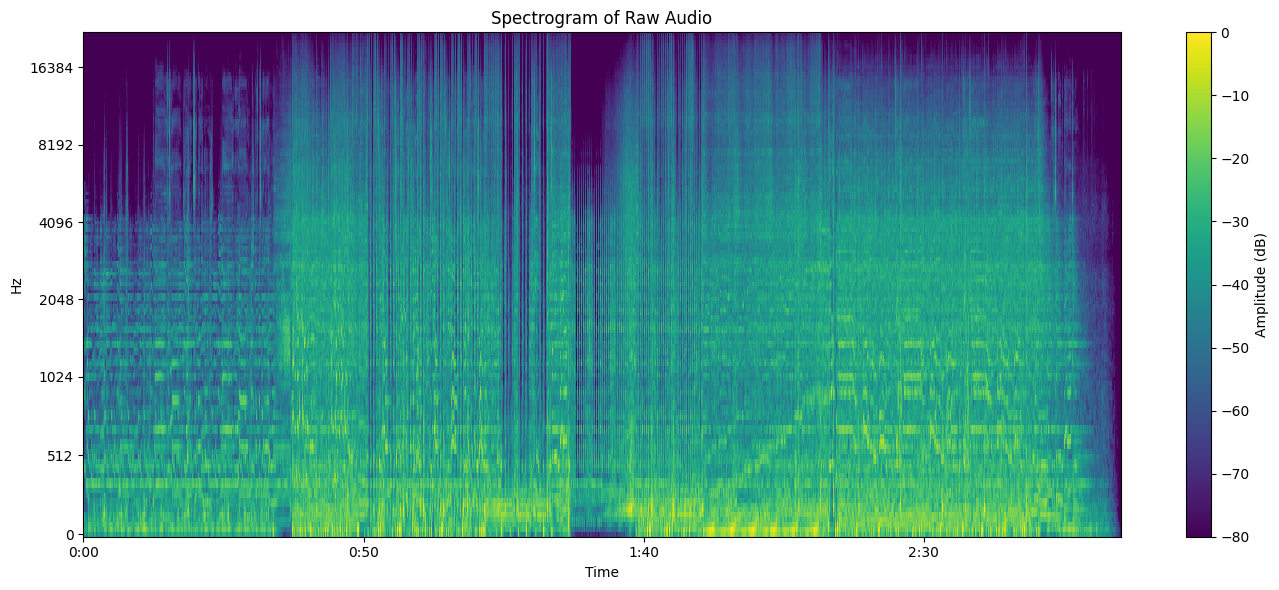

In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the denoised audio
audio_path = f"{artifacts_dir}/{input_file}"
y, sr = librosa.load(audio_path, sr=None)

# Compute the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(label='Amplitude (dB)')
plt.title('Spectrogram of Raw Audio')
plt.tight_layout()
plt.show()

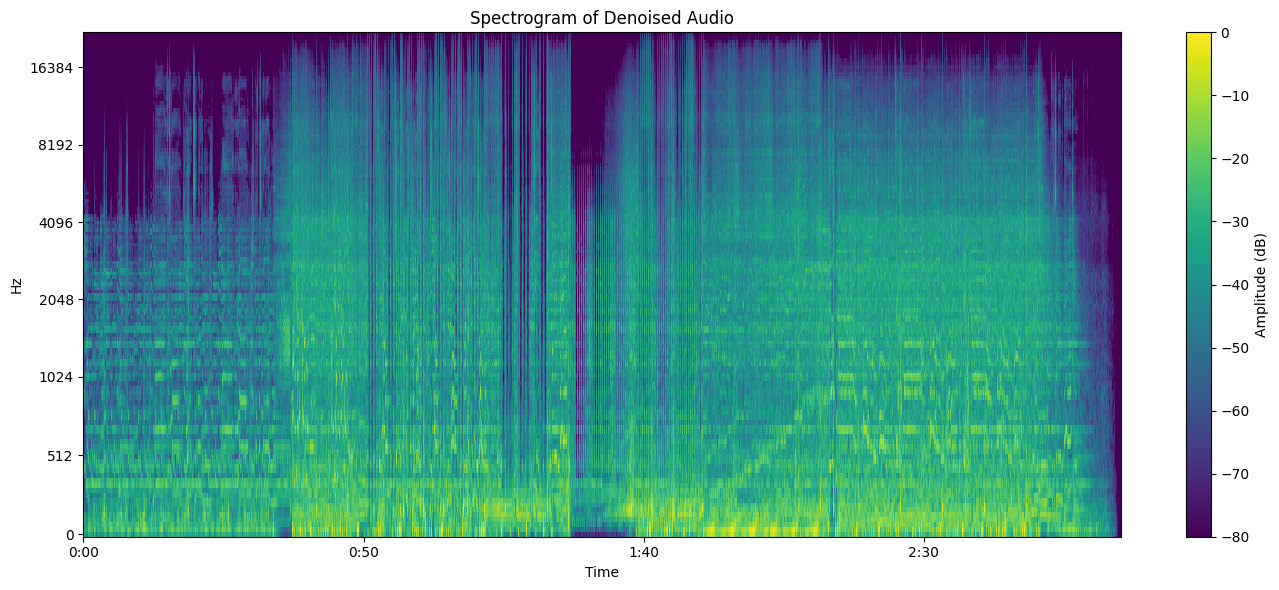

In [12]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the denoised audio
audio_path = f"{artifacts_dir}/{output_file}"
y, sr = librosa.load(audio_path, sr=None)

# Compute the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(label='Amplitude (dB)')
plt.title('Spectrogram of Denoised Audio')
plt.tight_layout()
plt.show()